In [1]:
import sympy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import dataset
import dataset_misc1d
import dataset_misc2d
from backprop import library, project, diversify
from gp import gp
from gp import creator as gp_creator
from gp import evaluator as gp_evaluator, selector as gp_selector
from gp import crossover as gp_crossover, mutator as gp_mutator
from gp import corrector as gp_corrector
from symbols import syntax_tree
import randstate

In [2]:
SAMPLE_SIZE = 100
TRAIN_SIZE  = 0.7
NOISE       = 0.0
MESH_SIZE   = 100

POPSIZE         = 200
MAX_STREE_DEPTH = 5
GENERATIONS     = 25
GROUP_SIZE      = 5  # tournament selector.
MUTATION_RATE   = 0.15
ELITISM         = 1

LIBSIZE      = 2000
LIB_MAXDEPTH = 3

RANDSTATE = 124

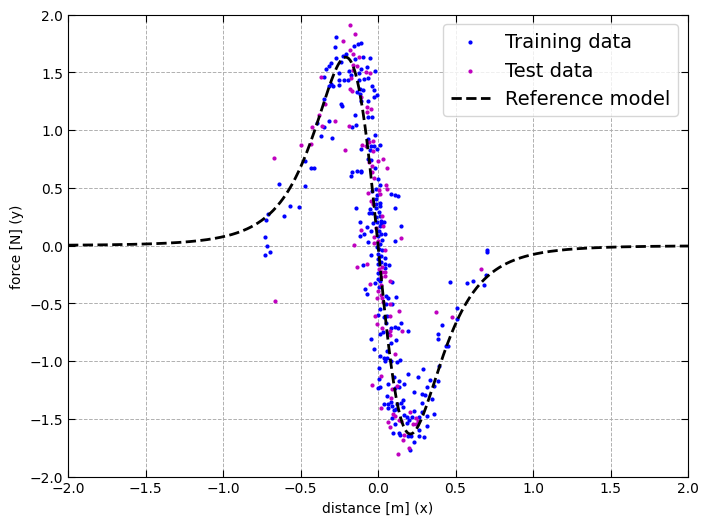

In [3]:
randstate.setstate(RANDSTATE)

S = dataset_misc1d.MagmanDatasetScaled()
#S = dataset_misc2d.Resistance2()
#S = dataset_misc1d.ABSDataset()

#S.sample(size=SAMPLE_SIZE, noise=NOISE, mesh=False)
S.load('../data/magman.csv')

S.split(train_size=TRAIN_SIZE)
S.get_plotter().plot(width=8, height=6, plot_knowldege=False)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [4]:
np.seterr(all='ignore')

syntax_tree.SyntaxTreeInfo.set_problem(S_train)

solutionCreator = gp_creator.RandomSolutionCreator(nvars=S.nvars)

multiMutator = gp_mutator.MultiMutator(
      gp_mutator.SubtreeReplacerMutator(MAX_STREE_DEPTH, solutionCreator),
      gp_mutator.FunctionSymbolMutator(),
      gp_mutator.NumericParameterMutator(all=True),
      #gp.NumericParameterMutator(all=False)
      )

X_mesh         = S_train.spsampler.meshspace(S_train.xl, S_train.xu, MESH_SIZE)
know_evaluator = gp_evaluator.KnowledgeEvaluator(S.knowledge, X_mesh)
r2_evaluator   = gp_evaluator.R2Evaluator(S_train)
evaluator      = gp_evaluator.LayeredEvaluator(know_evaluator, r2_evaluator)

selector  = gp_selector.TournamentSelector(GROUP_SIZE)
crossover = gp_crossover.SubTreeCrossover(MAX_STREE_DEPTH)
corrector = gp_corrector.Corrector(S_train, S.knowledge, MAX_STREE_DEPTH, X_mesh, LIBSIZE, LIB_MAXDEPTH)

symb_regressor = \
         gp.GP(POPSIZE, GENERATIONS, MAX_STREE_DEPTH, S_train, S_test,
               creator=solutionCreator,
               evaluator=evaluator,
               selector=selector,
               crossover=crossover,
               mutator=multiMutator,
               corrector=corrector,
               mutrate=MUTATION_RATE,
               elitism=ELITISM,
               knowledge=S.knowledge)

import profiling

with tqdm(total=symb_regressor.ngen-1) as pbar:
      def on_newgen(genidx, status):
            pbar.update(1)
            pbar.set_description(status)
      best_stree, best_eval = symb_regressor.evolve(newgen_callback=on_newgen)

profiling.print_stats()

print("\n--- Best syntax tree ---")
print(best_stree)
print(best_eval)
print(f"Max depth: {best_stree.get_max_depth()}")
#if corrector is not None: print(f"Lib radius faults: {corrector.lib.get_radius_faults()}")

  0%|          | 0/24 [00:00<?, ?it/s]

         2696097 function calls (2492821 primitive calls) in 8.611 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4800    0.082    0.000    8.605    0.002 corrector.py:21(correct)
     4430    0.050    0.000    6.191    0.001 library.py:497(cquery)
     3937    0.496    0.000    5.872    0.001 library.py:521(__local_cquery)
   229805    0.983    0.000    4.221    0.000 constraints.py:41(match_key)
   215453    0.372    0.000    3.239    0.000 <__array_function__ internals>:177(array_equal)
   215453    1.809    0.000    2.818    0.000 numeric.py:2407(array_equal)
     4800    0.051    0.000    1.540    0.000 corrector.py:60(backprop_know)
     5610    0.013    0.000    1.349    0.000 library.py:76(query)
     5610    0.991    0.000    1.337    0.000 _kdtree.py:363(query)
   433265    1.027    0.000    1.027    0.000 _methods.py:61(_all)
52566/8610    0.117    0.000    0.751    0.000 binop.py:27(__getitem__)
34446/21

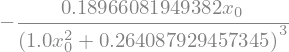

In [5]:
sympy.init_printing()
sympy.simplify(sympy.factor(best_stree.to_sympy()))

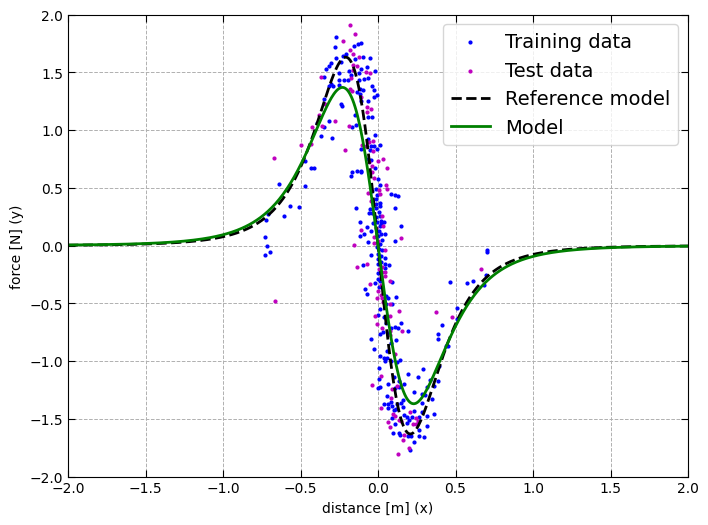

In [6]:
best_stree.clear_output()
S.get_plotter().plot(width=8, height=6, plot_knowldege=False, model=best_stree, zoomout=1)

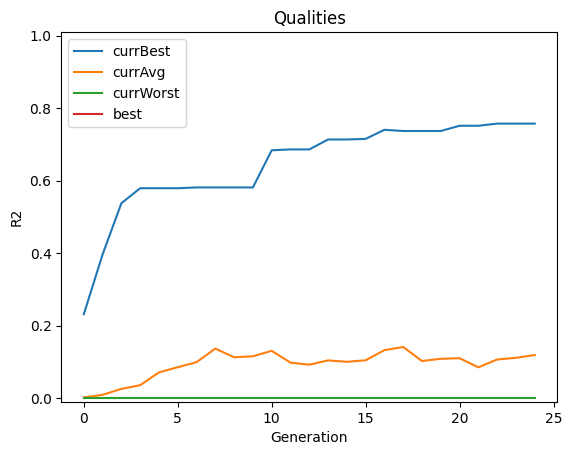

In [7]:
for quality, qseries in symb_regressor.stats.qualities.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('R2')
plt.title('Qualities')
plt.show()

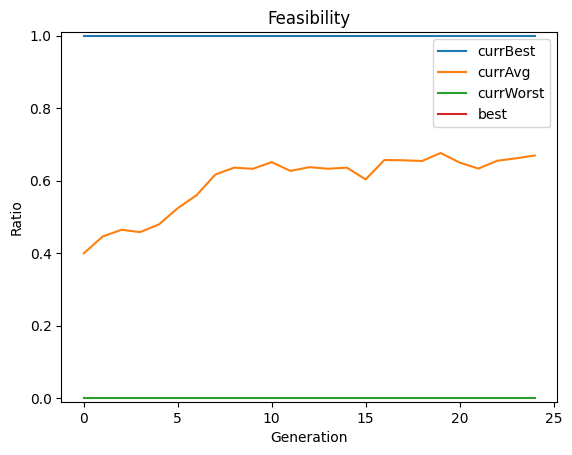

In [8]:
for quality, qseries in symb_regressor.stats.fea_ratio.items():
    plt.plot(qseries, label=quality)

plt.legend()
plt.ylim((-0.01, 1.01))
plt.xlabel('Generation')
plt.ylabel('Ratio')
plt.title('Feasibility')
plt.show()

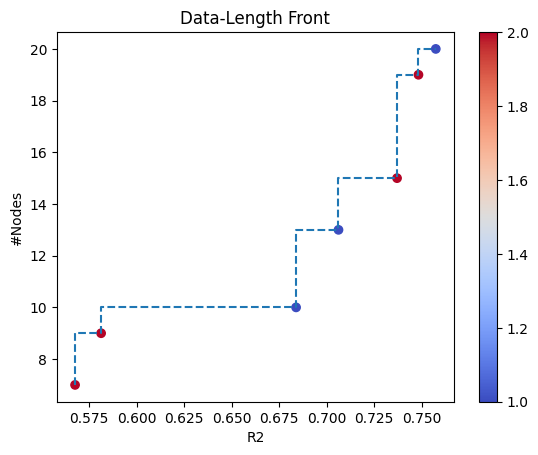

,Score,Model,Front,fpn,R2,Length,Symbset,Symbdist,Crowdist
0,0,((((0.26 * x0) * (0.89 * 0.87)) / cube(((0.14 ...,0,0.037876,0.757521,20,"(cube, *, /, exp, sqrt, +)",1,inf
1,1,((-0.65 * x0) / sqrt(square(x0))),0,0.081089,0.567624,7,"(sqrt, square, /)",2,inf
2,2,((x0 / -0.17) / sqrt(exp(square((x0 / -0.28))))),0,0.068398,0.683979,10,"(exp, sqrt, square, /)",1,0.965752
3,3,((-0.06 * (sqrt(square(x0)) / 0.09)) / x0),0,0.064593,0.581340,9,"(sqrt, square, /)",2,0.843493
4,4,(((x0 * 0.35) / cube(((0.13 - 0.44) - square(x...,0,0.049141,0.737122,15,"(cube, /, square, exp, sqrt, +)",2,0.683224
5,5,(((x0 * 0.35) / cube(((0.13 - 0.44) - square(x...,0,0.054331,0.706304,13,"(cube, +, square, /)",1,0.664468
6,6,((((x0 * 0.88) * 0.35) / cube(((0.13 - 0.44) -...,0,0.039390,0.748401,19,"(cube, /, square, exp, sqrt, +)",2,0.492040
7,0,((-0.06 * x0) / sqrt(square(x0))),1,0.013052,0.091363,7,"(sqrt, square, /)",1,inf
8,1,((((0.26 * x0) * (0.89 * 0.87)) / cube(((0.14 ...,1,0.037867,0.757346,20,"(cube, *, /, exp, sqrt, +)",1,inf
9,2,((sqrt(square(x0)) * log(0.36)) / x0),1,0.066660,0.533283,8,"(*, log, square, sqrt, /)",1,0.875627


In [9]:
pd_data = []
front_tracker = symb_regressor.fea_front_tracker.front_tracker_a

for frontidx in range(front_tracker.nfronts):

    front = front_tracker.get_front(frontidx)
    symbset, symbdist = front_tracker.compute_symbdist(frontidx)
    crowdist = front_tracker.compute_crowdist(frontidx)
    
    for idx, (stree, data, length) in enumerate(front):
        pd_data.append(
            [idx, stree, frontidx, data/length, data, length, symbset[id(stree)], symbdist[id(stree)], crowdist[id(stree)]]
        )

front_tracker.plot(0)
pd.DataFrame(pd_data, columns=['Score', 'Model', 'Front', 'fpn', 'R2', 'Length', 'Symbset', 'Symbdist', 'Crowdist']).head(n=60)
#print(front_tracker.symbfreq.freq)
#print(symb_regressor.fea_front_tracker.front_tracker_b.symbfreq.freq)